In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, mutual_info_score, recall_score, accuracy_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import cv



In [ ]:
# prompt: connrct to drive

from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **LOADING DATA**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/creditriskanalysis/credit_risk_dataset.csv")
df.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3


In [ ]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [ ]:
df.shape

(32581, 12)

## ***DATA PREPROCESSING***

In [ ]:
# unique values of each object column
for col in df.select_dtypes(include=['object']):
    print(col, ":" ,df[col].unique())

person_home_ownership : ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent : ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade : ['D' 'B' 'C' 'A' 'E' 'F' 'G']
cb_person_default_on_file : ['Y' 'N']


In [ ]:
# check for other missing value percentage
(df.isnull().sum() / len(df)).sort_values(ascending=False) * 100

loan_int_rate                 9.563856
person_emp_length             2.747000
person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

In [ ]:
# dropping the missing values
df.dropna(inplace=True)


In [ ]:
df = df.drop_duplicates()


In [ ]:
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

Dropped missing values and duplicates in the dataset.

## **EXPLORATORY DATA ANALYSIS(EDA)**

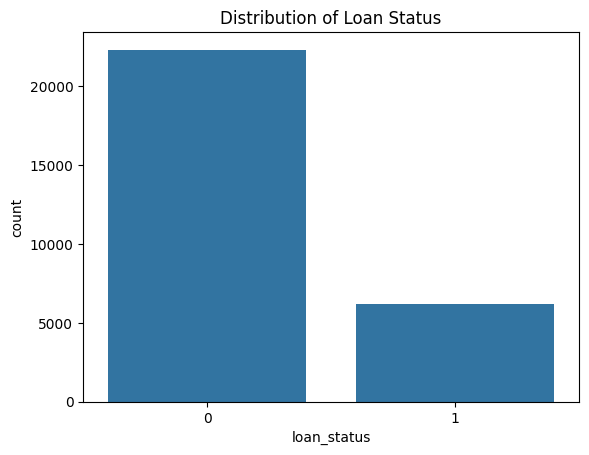

In [ ]:
# Distribution of the target variable 'loan_status'
sns.countplot(x='loan_status', data=df)
plt.title('Distribution of Loan Status')
plt.show()


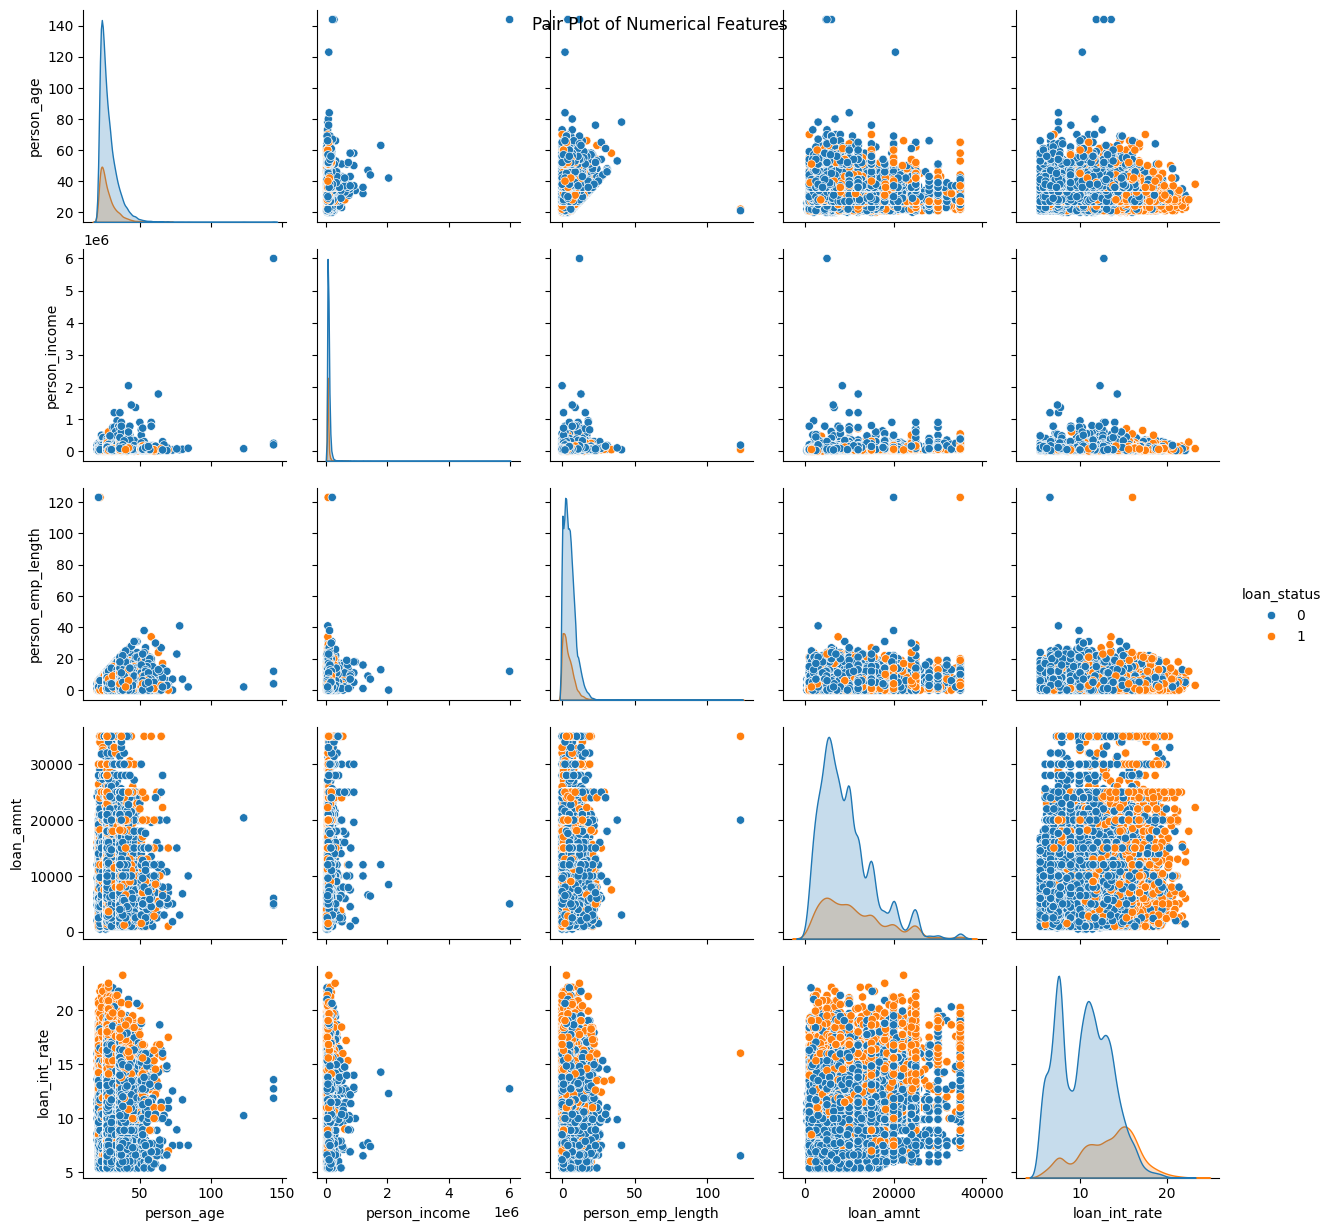

In [ ]:

# Pair plot for numerical features
num_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate']

sns.pairplot(df[num_features + ['loan_status']], hue='loan_status')

plt.suptitle('Pair Plot of Numerical Features')
plt.show()



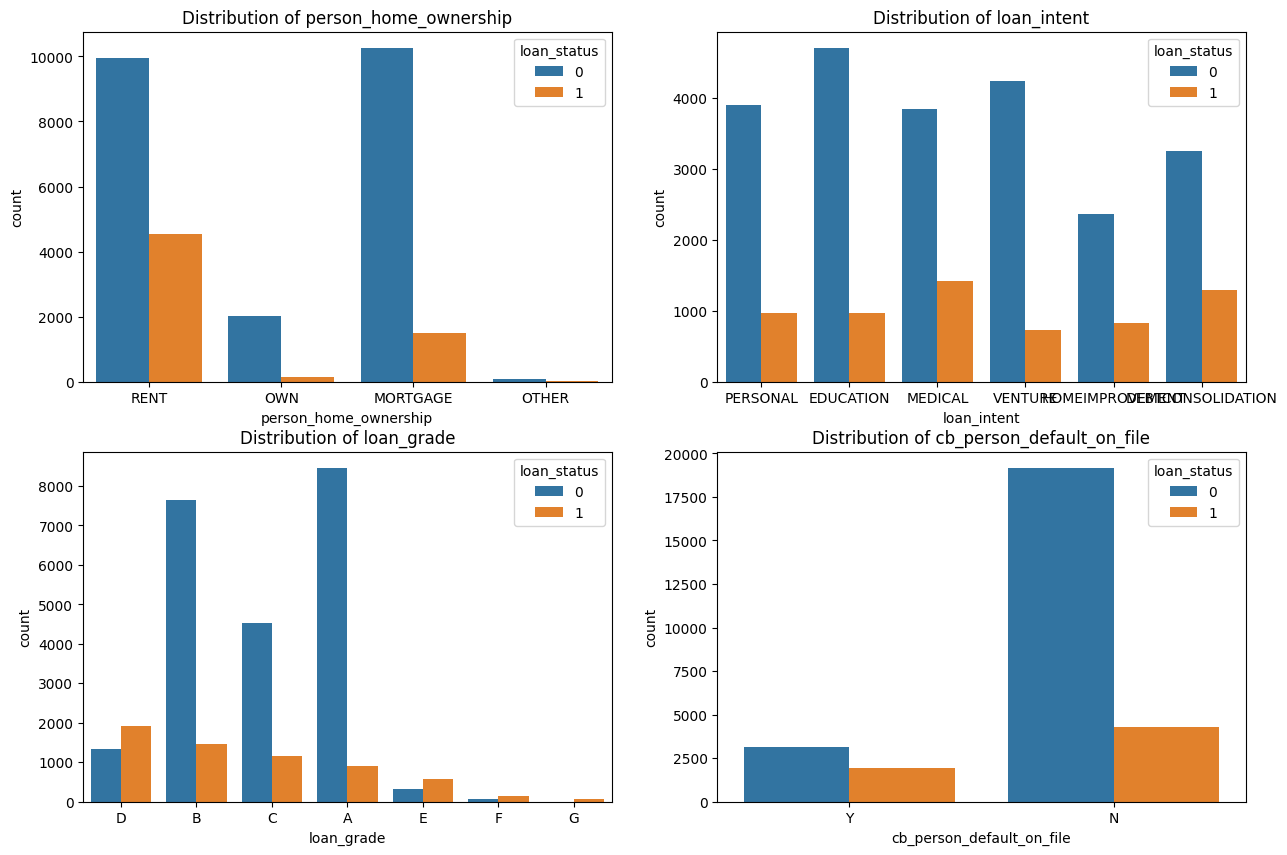

In [ ]:
# Distribution of categorical features
cat_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=feature, data=df, hue='loan_status')
    plt.title(f'Distribution of {feature}')
plt.show()

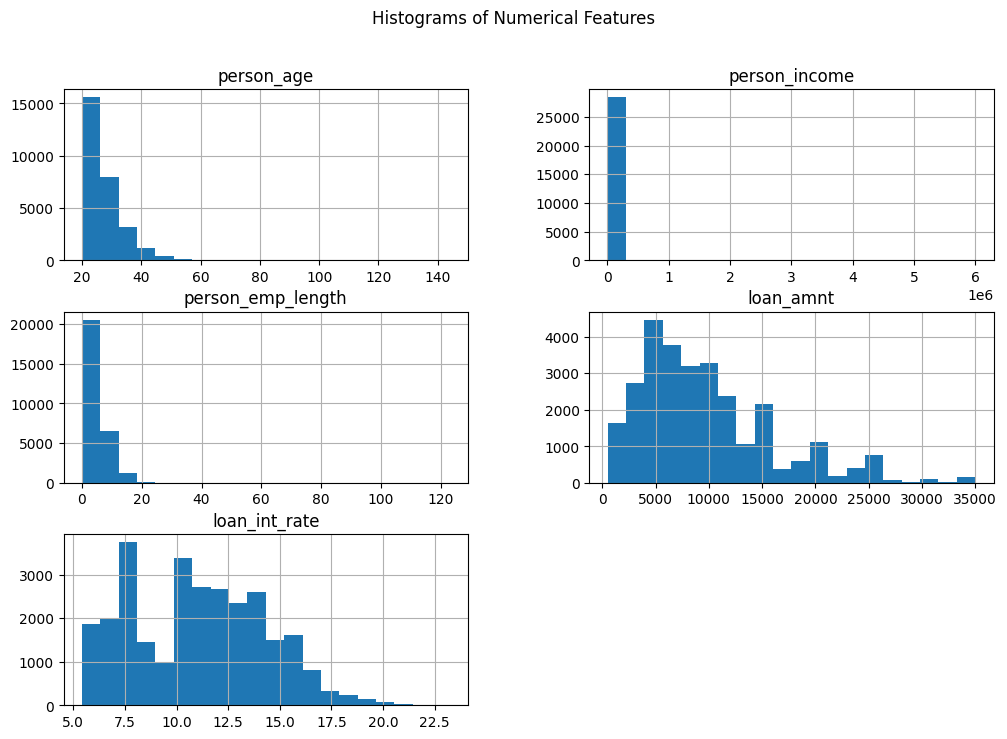

In [ ]:
# Distribution of numerical features
num_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate']
df[num_features].hist(figsize=(12, 8), bins=20)
plt.suptitle('Histograms of Numerical Features')
plt.show()


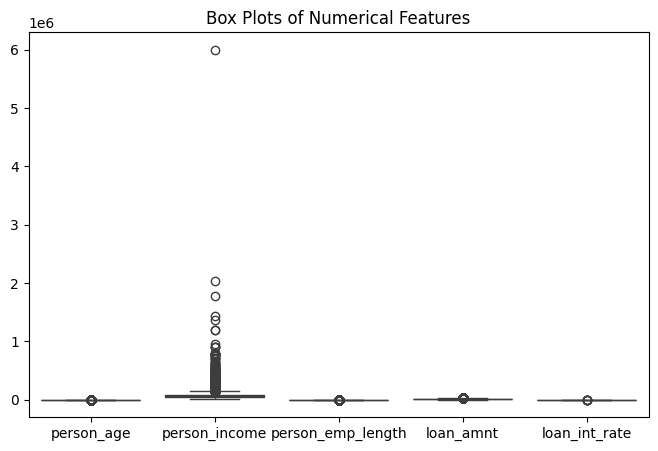

In [ ]:

# Box plots for numerical features
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[num_features])
plt.title('Box Plots of Numerical Features')
plt.show()



Text(0.5, 1.0, "Person's Age Distribution")

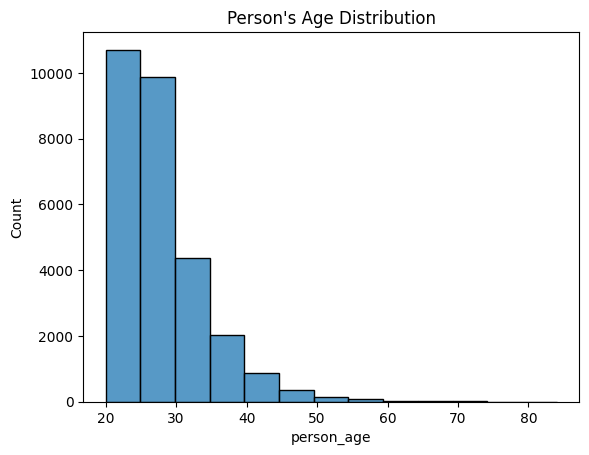

In [ ]:
# assuming a persons limit is less than 90 years old for loan eligibility
df2 = df.loc[(df['person_age'] <= 90) &  (df['person_income'] < 6e6) ]
# age distribution
sns.histplot(data=df2, x ='person_age', binwidth=5)
plt.title("Person's Age Distribution")

<ipython-input-17-13c4763a1420>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df2.corr()


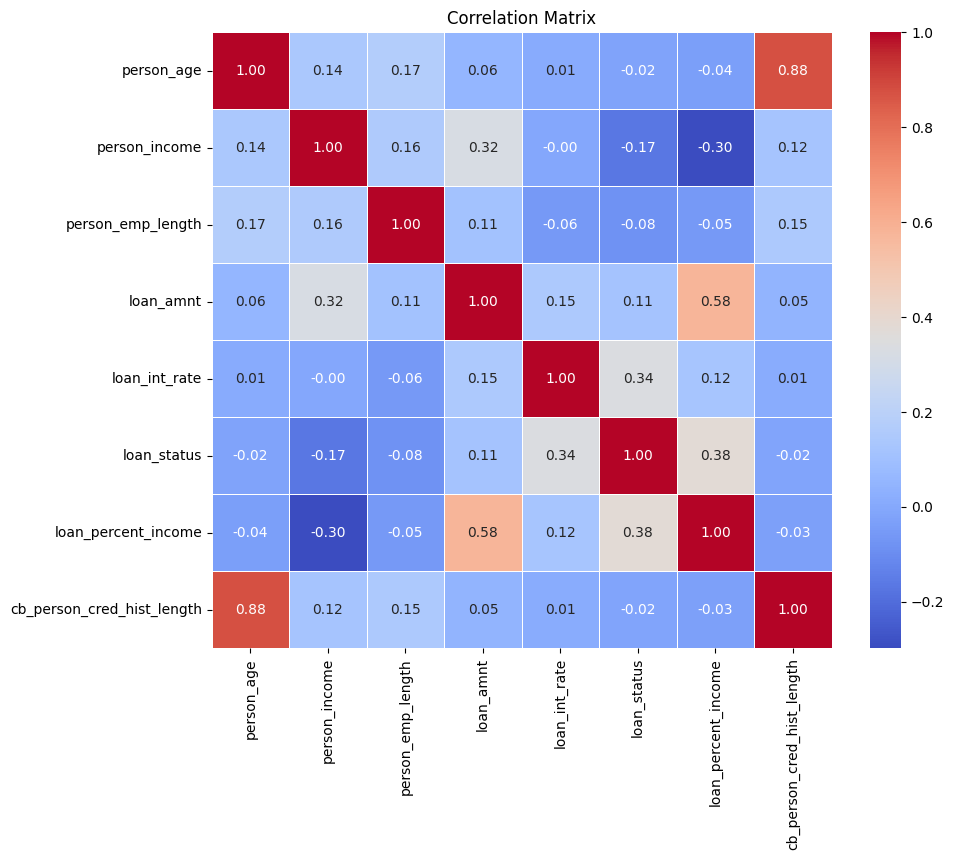

In [ ]:
# Correlation matrix
correlation_matrix = df2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Selecting final set of features

In [ ]:
# Convert Yes and No values to 0 and 1
data_df=df2.copy()
data_df['cb_person_default_on_file']=data_df.cb_person_default_on_file.map(dict(Y=1, N=0))

In [ ]:
data_df.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,1,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,0,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,0,3


In [ ]:
# drop a feature
df=data_df.drop(['cb_person_cred_hist_length', 'person_age'],axis=1)

In [ ]:
# select the final set of features
selected_features = df.drop(['loan_intent', 'person_home_ownership'], axis=1)

# Label encoding

In [ ]:
# Label encoding for loan grade
le = preprocessing.LabelEncoder()
selected_features['loan_grade'] = le.fit_transform(selected_features.loan_grade.values)


In [ ]:
selected_features.head(3)

,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file
0,59000,123.0,3,35000,16.02,1,0.59,1
1,9600,5.0,1,1000,11.14,0,0.10,0
2,9600,1.0,2,5500,12.87,1,0.57,0


# Model Training

In [ ]:
def model_performance(y_test,y_pred, method):

    # calculate the accruacy of the model
    print("Accuracy score of the model", accuracy_score(y_test,y_pred))
    print("Classification report \n")

    #generate the classification report
    print(classification_report(y_test,y_pred))

    #generate the confusion matrix
    fig = plt.figure(figsize = (4,4))
    ax = fig.gca()
    cnf_matrix_log = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix_log), annot=True,cmap="Reds" , fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix: '+  method + '\n', y=1.1)


Train/Test split of data

In [ ]:
# select the features and the target variables
X = selected_features.drop(['loan_status'],axis=1)
y = selected_features['loan_status']

# Train/ Test Split using stratify sampling to solve the class imbalance problem
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=33)

Logistic Regression

Accuracy score of the model 0.8057894736842105
Classification report 

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      4462
           1       0.72      0.17      0.28      1238

    accuracy                           0.81      5700
   macro avg       0.77      0.58      0.58      5700
weighted avg       0.79      0.81      0.76      5700



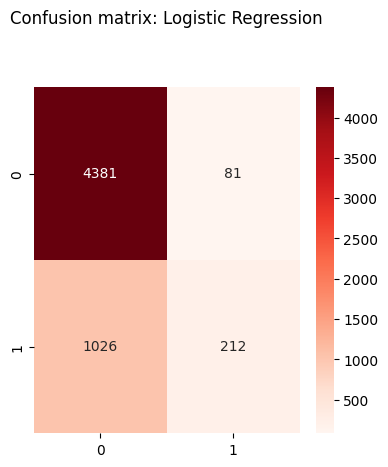

In [ ]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
# Calculate Accuracy
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
# Evaluate and visualize performance using the 'model_performance' function
model_performance(y_test, y_pred_logistic, method='Logistic Regression')

plt.show()

Decision Trees

Accuracy score of the model 0.846140350877193
Classification report 

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4462
           1       0.64      0.66      0.65      1238

    accuracy                           0.85      5700
   macro avg       0.77      0.78      0.78      5700
weighted avg       0.85      0.85      0.85      5700



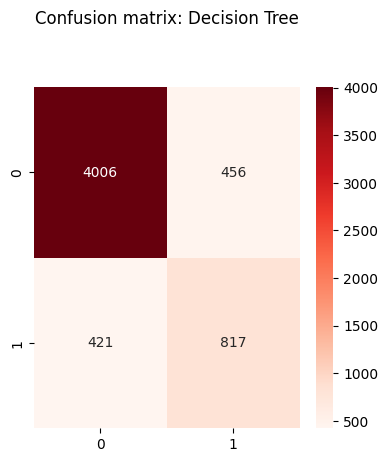

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)
y_pred_decision_tree = decision_tree_model.predict(X_test)

# Calculate Accuracy
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
# Evaluate and visualize performance using the 'model_performance' function
model_performance(y_test, y_pred_decision_tree, method='Decision Tree')

plt.show()

Randome Forest Classifier

Accuracy score of the model 0.885438596491228
Classification report 

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4462
           1       0.78      0.66      0.71      1238

    accuracy                           0.89      5700
   macro avg       0.84      0.80      0.82      5700
weighted avg       0.88      0.89      0.88      5700



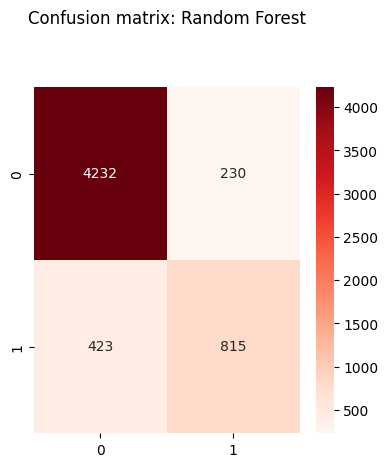

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)
y_pred_random_forest = random_forest_model.predict(X_test)

# Calculate Accuracy
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
# Evaluate and visualize performance using the 'model_performance' function
model_performance(y_test, y_pred_random_forest, method='Random Forest')

plt.show()

Gradient Boosting classifier(XGBoost)

Accuracy score of the model 0.882280701754386
Classification report 

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      4462
           1       0.77      0.66      0.71      1238

    accuracy                           0.88      5700
   macro avg       0.84      0.80      0.82      5700
weighted avg       0.88      0.88      0.88      5700



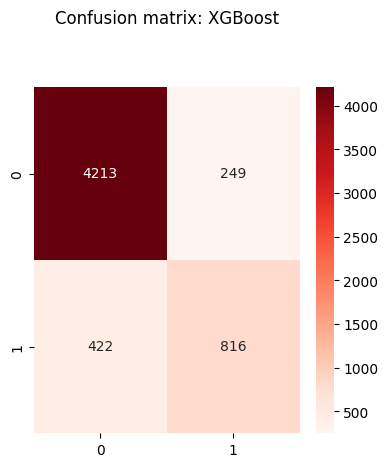

In [ ]:
from xgboost import XGBClassifier
# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Calculate Accuracy
accuracy_xgboost = accuracy_score(y_test, y_pred_xgb)
# Evaluate and visualize performance using the 'model_performance' function
model_performance(y_test, y_pred_xgb, method='XGBoost')

plt.show()

In [ ]:
# Assuming you have obtained accuracies for each model
model_accuracies = {'Logistic Regression': accuracy_logistic, 'Decision Tree': accuracy_decision_tree,
                    'Random Forest': accuracy_random_forest, 'XGBoost': accuracy_xgboost}

best_model = max(model_accuracies, key=model_accuracies.get)
print(f"The best-performing model is: {best_model} with accuracy {model_accuracies[best_model]}")


The best-performing model is: Random Forest with accuracy 0.885438596491228


In [ ]:
# Assuming you have obtained model predictions for each model
model_predictions = {'Logistic Regression': y_pred_logistic, 'Decision Tree': y_pred_decision_tree,
                     'Random Forest': y_pred_random_forest, 'XGBoost': y_pred_xgb}

for model_name, predictions in model_predictions.items():
    print(f"Metrics for {model_name}:")
    print(classification_report(y_test, predictions))

Metrics for Logistic Regression:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      4462
           1       0.72      0.17      0.28      1238

    accuracy                           0.81      5700
   macro avg       0.77      0.58      0.58      5700
weighted avg       0.79      0.81      0.76      5700

Metrics for Decision Tree:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4462
           1       0.64      0.66      0.65      1238

    accuracy                           0.85      5700
   macro avg       0.77      0.78      0.78      5700
weighted avg       0.85      0.85      0.85      5700

Metrics for Random Forest:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4462
           1       0.78      0.66      0.71      1238

    accuracy                           0.89      5700
   macro avg       0.84      0.80      0.

In [ ]:
## Assuming you have trained tree-based models
tree_based_models = {'Decision Tree': decision_tree_model, 'Random Forest': random_forest_model,
                     'XGBoost': xgb_model}

for model_name, model in tree_based_models.items():
    if hasattr(model, 'feature_importances_'):
        feature_importance = dict(zip(X.columns, model.feature_importances_))
        sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
        print(f"\nFeature Importance for {model_name}:\n")
        for feature, importance in sorted_feature_importance:
            print(f"{feature}: {importance}")




Feature Importance for Decision Tree:

loan_percent_income: 0.2793177641015888
person_income: 0.221104803938079
loan_grade: 0.1672725153037742
loan_int_rate: 0.13106448433406181
person_emp_length: 0.10118464269466108
loan_amnt: 0.0885599670948752
cb_person_default_on_file: 0.011495822532959877

Feature Importance for Random Forest:

loan_percent_income: 0.24185270162590636
person_income: 0.2250424223714848
loan_int_rate: 0.18110048201067602
loan_amnt: 0.1193489352844053
loan_grade: 0.1188534191560046
person_emp_length: 0.09980290839032684
cb_person_default_on_file: 0.013999131161196141

Feature Importance for XGBoost:

loan_grade: 0.5735296010971069
loan_percent_income: 0.23240762948989868
person_income: 0.07237404584884644
person_emp_length: 0.0387786440551281
loan_int_rate: 0.03394419327378273
loan_amnt: 0.028411978855729103
cb_person_default_on_file: 0.020553914830088615
